In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Problem Definition

1. Variables that need Monte Carlo sampling:
  1. For elemental constraint:
    1. $m$, mass fraction of carbonate, tentative set to range from 0.99 to 0.999
    2. [Ca]$_c$, mass fraction of Ca in carbonate, range from 40/184 to 40/100
        1. fixed to 40/184 for dolomite only
    3. [Mg]$_c$, mass fraction of Mg in carbonate, range from 0 to 24/184
        1. fixed to 24/184 for dolomite only
    4. [Ca]$_a$, mass fraction of Ca in clay, range from 0 to 0.0073
    5. [Mg]$_a$, mass fraction of Mg in clay, range from 0 to 0.0868
    6. [Al]$_a$, mass fraction of Al in carbonate, range from 0 to 0.2301
  2. For Li isotope constraint:
    1. [Li]$_c$, mass fraction of Li in carbonate, fixed to 10$^{-6}$
    2. $\delta_c$, Li isotope value of carbonate, fixed to 0.018
    3. [Li]$_a$, mass fraction of Li in clay, range 9.61x10$^{-6}$ to 187.6x10$^{-6}$
    4. $\delta_a$, Li isotope value of clay, range from -0.0141 to 0.0059
2. The elemental constraint is:
$$\frac{[\mathrm{Al}]_t}{[\mathrm{Mg}]_t + [\mathrm{Ca}]_t} = \frac{[\mathrm{Al}]_a(1-m)}{\left( [\mathrm{Mg}]_c+[\mathrm{Ca}]_c \right)m + \left( [\mathrm{Mg}]_a +[\mathrm{Ca}]_a \right)(1-m)} = 1.44\times10^{-3}$$
3. The Li isotope constraint is:
$$\delta_t = \frac{[\mathrm{Li}]_c \delta_c m + [\mathrm{Li}]_a \delta_a (1-m)}{[\mathrm{Li}]_c m + [\mathrm{Li}]_a (1-m)} = -0.0007$$

## Model Strategy
1. The two constraints contain only one variable in common: $m$, so we can start from Li isotope constraint that contains less variable to match $m$ first.
2. Within the matched $m$ values, we resample $m$ together with other variables for the elemental constraint to further refine $m$ values.
3. So the two constraints leads to two matching processes, which can reduce the computational cost.

In [2]:
import numpy as np
import scipy.integrate
import scipy.optimize as opt
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# to store matched values
m_lia  = []
m_dlia = []
m_m    = []

# total sampling points
# t_lia    = []
# t_dlia   = []
# t_m      = []
# t_dlia_t = []

# sampled variable values
sz     = 1000
m      = np.linspace(0.95, 1.0, sz, endpoint=True)           # calcite mass fraction
lia    = np.linspace(9.61e-6, 1.876e-4, sz, endpoint=True)     # clay Li content
dlia   = np.linspace(-0.0141, 0.0059, sz, endpoint=True)       # clay Li isotope

# fixed values
lic    = 1e-6      # carbonate Li concentration
dlic   = 0.018     # carbonate Li isotope

# matching target and threshold
m_target    = -0.0007
m_threshold = 1e-2

for m_lp in m:
    for lia_lp in lia:
        for dlia_lp in dlia:
            dlia_t = (lic*dlic*m_lp + lia_lp*dlia_lp*(1-m_lp))/(lic*m_lp + lia_lp*(1-m_lp))
#             t_dlia.append(dlia_lp)
#             t_lia.append(lia_lp)
#             t_m.append(m_lp)
#             t_dlia_t.append(dlia_t)
            if np.absolute((dlia_t - m_target)/m_target) <= m_threshold:
                m_dlia.append(dlia_lp)
                m_lia.append(lia_lp)
                m_m.append(m_lp)

m_dlia = np.array(m_dlia)
m_lia  = np.array(m_lia)
m_m    = np.array(m_m)

# t_dlia   = np.array(t_dlia)
# t_lia    = np.array(t_lia)
# t_m      = np.array(t_m)
# t_dlia_t = np.array(t_dlia_t)

# save data
np.savez('./Li_const.npz', m_m=m_m, m_lia=m_lia, m_dlia=m_dlia)

Text(0.5, 1.0, 'Clay Li Isotope (per mil)')

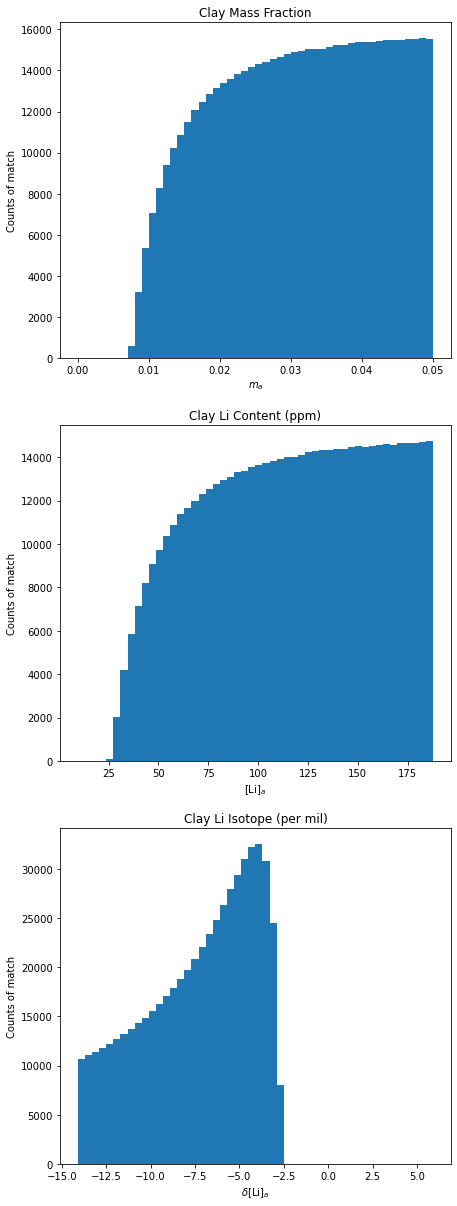

In [4]:
# Plot the distribution of matched values
f = plt.figure(figsize=(7,21))   # results after matching dlia_t = -0.0007

plt.subplot(3,1,1)
plt.hist(1-m_m, range=(1-m.max(), 1-m.min()), density=False, bins=50)  # density=False would make counts
plt.ylabel('Counts of match')
plt.xlabel(r'$m_a$');
plt.title('Clay Mass Fraction')

plt.subplot(3,1,2)
plt.hist(m_lia*1e6, range=(lia.min()*1e6, lia.max()*1e6), density=False, bins=50)
plt.ylabel('Counts of match')
plt.xlabel(r'[Li]$_a$');
plt.title('Clay Li Content (ppm)')

plt.subplot(3,1,3)
plt.hist(m_dlia*1e3, range=(dlia.min()*1e3, dlia.max()*1e3), density=False, bins=50) 
plt.ylabel('Counts of match')
plt.xlabel(r'$\delta$[Li]$_a$');
plt.title('Clay Li Isotope (per mil)')

Text(0.5, 1.0, 'Clay Li Isotope (per mil)')

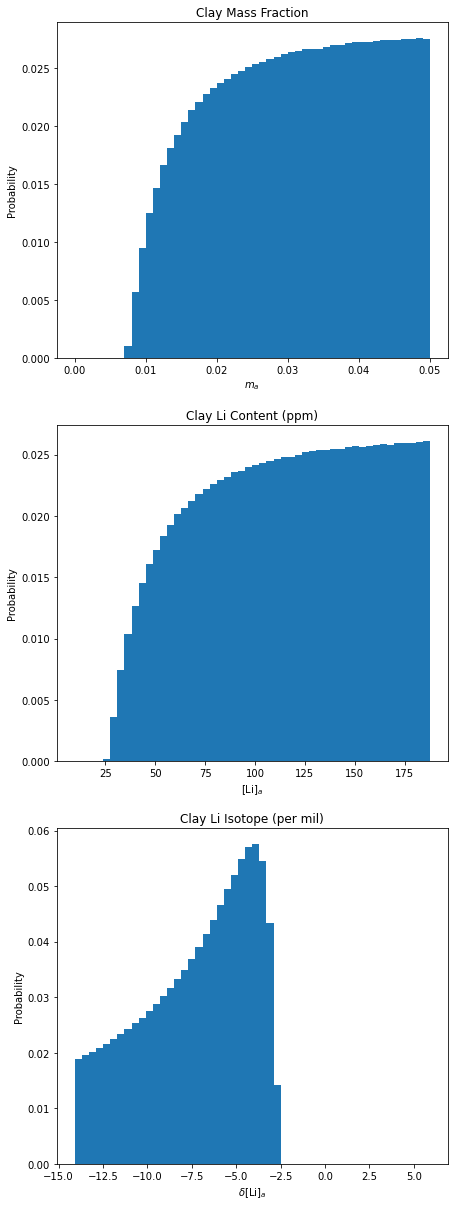

In [5]:
# Plot the distribution of matched values
f = plt.figure(figsize=(7,21))   # results after matching dlia_t = -0.0007

weights = np.ones_like(m_m) / len(m_m)
plt.subplot(3,1,1)
plt.hist(1-m_m, range=(1-m.max(), 1-m.min()), weights=weights, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel(r'$m_a$');
plt.title('Clay Mass Fraction')

weights = np.ones_like(m_lia) / len(m_lia)
plt.subplot(3,1,2)
plt.hist(m_lia*1e6, range=(lia.min()*1e6, lia.max()*1e6), weights=weights, bins=50)
plt.ylabel('Probability')
plt.xlabel(r'[Li]$_a$');
plt.title('Clay Li Content (ppm)')

weights = np.ones_like(m_dlia) / len(m_dlia)
plt.subplot(3,1,3)
plt.hist(m_dlia*1e3, range=(dlia.min()*1e3, dlia.max()*1e3), weights=weights, bins=50) 
plt.ylabel('Probability')
plt.xlabel(r'$\delta$[Li]$_a$');
plt.title('Clay Li Isotope (per mil)')

In [14]:
# Based on the matched m values, launch another Monte Carlo simulation to match the elemental constraint

# to store matched values
m_m2   = []
# m_cac  = np.array([])  # commented out for pure carbonate of only dolomite
# m_mgc  = np.array([])  # commented out for pure carbonate of only dolomite
m_caa  = []
m_mga  = []
m_ala  = []

# total sampling points
# t_m2   = []
# t_caa  = []
# t_mga  = []
# t_ala  = []
# t_ratio  = []

# sampled variable values
sz     = 500
m2     = np.random.uniform(m_m.min(), m_m.max(), sz)           # resample carbonate mass fraction
# cac    = np.linspace(40/184, 0.04, sz, endpoint=True)          # Ca mass fraction in carbonate
# mgc    = np.linspace(0, 24/184, sz, endpoint=True)             # Mg mass fraction in carbonate
caa    = np.linspace(0, 0.0073, sz, endpoint=True)             # Ca mass fraction in clay
mga    = np.linspace(0, 0.0868, sz, endpoint=True)             # Mg mass fraction in clay
ala    = np.linspace(0, 0.2301, sz, endpoint=True)             # Al mass fraction in clay

# fixed values

cac    = 40/184
mgc    = 24/184

# matching target and threshold
m_target2    = 1.44e-3
m_threshold2 = 1e-2

for m_lp in m2:
    for caa_lp in caa:
        for mga_lp in mga:
            for ala_lp in ala:
                ratio = (1-m_lp)*ala_lp/(m_lp*(cac + mgc) + (1-m_lp)*(caa_lp + mga_lp))
#                 t_m2.append(m_lp)
#                 t_caa.append(caa_lp)
#                 t_mga.append(mga_lp)
#                 t_ala.append(ala_lp)
#                 t_ratio.append(ratio)
                if np.absolute((ratio - m_target2)/m_target2) <= m_threshold2:
                    m_ala.append(ala_lp)
                    m_mga.append(mga_lp)
                    m_caa.append(caa_lp)
#                    m_mgc.append(mgc_lp)
#                    m_cac.append(cac_lp)
                    m_m2.append(m_lp)

m_ala = np.array(m_ala)
m_mga = np.array(m_mga)
m_caa = np.array(m_caa)
m_m2  = np.array(m_m2)

# t_m2     = np.array(t_m2)
# t_caa    = np.array(t_caa)
# t_mga    = np.array(t_mga)
# t_ala    = np.array(t_ala)
# t_ratio  = np.array(t_ratio)

# save data
np.savez('./Ele_const.npz', m_ala=m_ala, m_mga=m_mga, m_caa=m_caa, m_m2=m_m2)

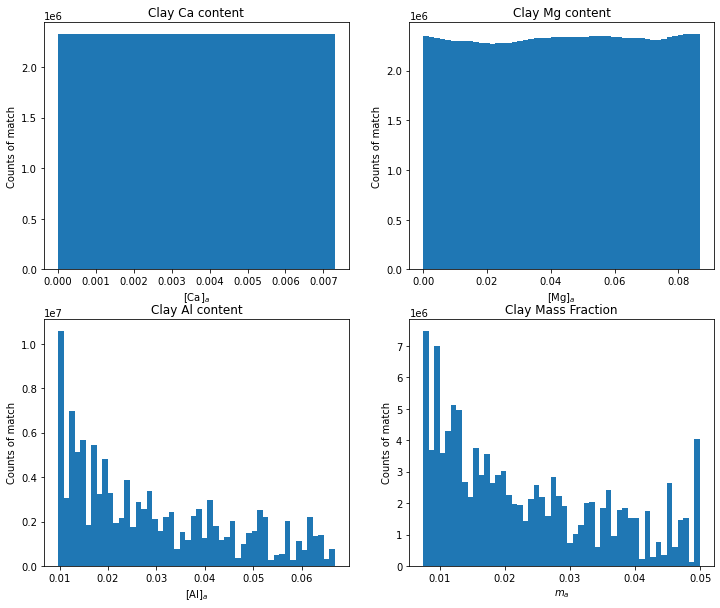

In [15]:
with np.load('./Ele_const.npz') as data:
    
    m_caa = data['m_caa']
    m_mga = data['m_mga']
    m_ala = data['m_ala']
    m_m2  = data['m_m2']

    # Plot the distribution of matched values
    f = plt.figure(figsize=(12,10))   # results after matching elemental ratio

    plt.subplot(2,2,1)
    plt.hist(m_caa, density=False, bins=50) 
    plt.ylabel('Counts of match')
    plt.xlabel(r'[Ca]$_a$');
    plt.title('Clay Ca content')

    plt.subplot(2,2,2)
    plt.hist(m_mga, density=False, bins=50) 
    plt.ylabel('Counts of match')
    plt.xlabel(r'[Mg]$_a$');
    plt.title('Clay Mg content')

    plt.subplot(2,2,3)
    plt.hist(m_ala, density=False, bins=50) 
    plt.ylabel('Counts of match')
    plt.xlabel(r'[Al]$_a$');
    plt.title('Clay Al content')

    plt.subplot(2,2,4)
    plt.hist(1-m_m2, density=False, bins=50)  # density=False would make counts
    plt.ylabel('Counts of match')
    plt.xlabel(r'$m_a$');
    plt.title('Clay Mass Fraction')

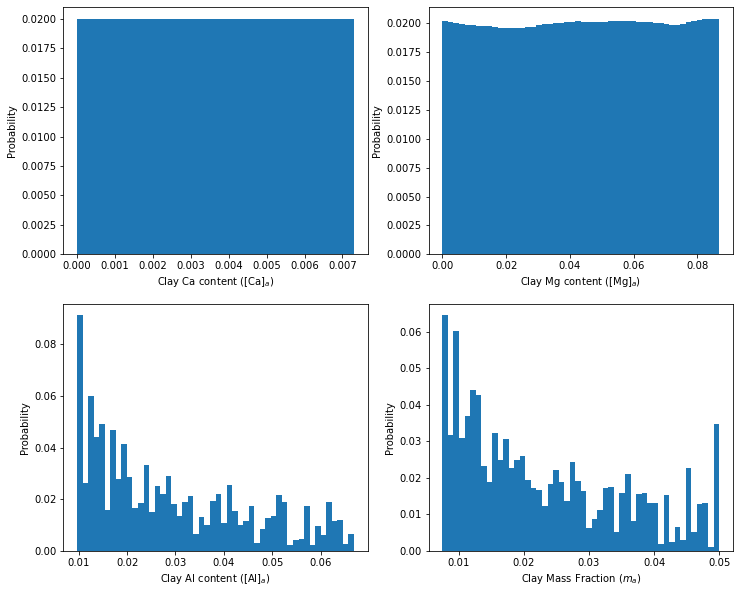

In [16]:
# Probability Density Distribution (PDF)
with np.load('./Ele_const.npz') as data:

    m_caa = data['m_caa']
    m_mga = data['m_mga']
    m_ala = data['m_ala']
    m_m2  = data['m_m2']

    # Plot the distribution of matched values
    f = plt.figure(figsize=(12,10))   # results after matching elemental ratio

    weights = np.ones_like(m_caa) / len(m_caa)
    plt.subplot(2,2,1)
    plt.hist(m_caa, weights=weights, bins=50) 
    plt.ylabel('Probability')
    plt.xlabel(r'Clay Ca content ([Ca]$_a$)');

    weights = np.ones_like(m_mga) / len(m_mga)
    plt.subplot(2,2,2)
    plt.hist(m_mga,weights=weights, bins=50) 
    plt.ylabel('Probability')
    plt.xlabel(r'Clay Mg content ([Mg]$_a$)');

    weights = np.ones_like(m_ala) / len(m_ala)
    plt.subplot(2,2,3)
    plt.hist(m_ala,weights=weights, bins=50) 
    plt.ylabel('Probability')
    plt.xlabel(r'Clay Al content ([Al]$_a$)');

    weights = np.ones_like(m_m2) / len(m_m2)
    plt.subplot(2,2,4)
    plt.hist(1-m_m2,weights=weights, bins=50)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel(r'Clay Mass Fraction ($m_a$)');
    
    plt.tight_layout

In [17]:
# Based on the matched m values, launch another Monte Carlo simulation to match the elemental constraint

# to store matched values
m_m2   = []
# m_cac  = np.array([])  # commented out for pure carbonate of only dolomite
# m_mgc  = np.array([])  # commented out for pure carbonate of only dolomite
# m_caa  = []
# m_mga  = []
m_ala  = []

# total sampling points
# t_m2   = []
# t_caa  = []
# t_mga  = []
# t_ala  = []
# t_ratio  = []

# sampled variable values
sz     = 50000
m2     = np.linspace(0.95, 1.0, sz, endpoint=True)               # carbonate mass fraction
# cac    = np.linspace(40/184, 0.04, sz, endpoint=True)          # Ca mass fraction in carbonate
# mgc    = np.linspace(0, 24/184, sz, endpoint=True)             # Mg mass fraction in carbonate
# caa    = np.linspace(0, 0.0073, sz, endpoint=True)             # Ca mass fraction in clay
# mga    = np.linspace(0, 0.0868, sz, endpoint=True)             # Mg mass fraction in clay
ala    = np.linspace(0, 0.2301, sz, endpoint=True)             # Al mass fraction in clay

# fixed values

cac    = 40/184
mgc    = 24/184
caa    = 0.0073/2
mga    = 0.0868/2

# matching target and threshold
m_target2    = 1.44e-3
m_threshold2 = 1e-2

for m_lp in m2:
    for ala_lp in ala:
        ratio = (1-m_lp)*ala_lp/(m_lp*(cac + mgc) + (1-m_lp)*(caa + mga))
        if np.absolute((ratio - m_target2)/m_target2) <= m_threshold2:
            m_ala.append(ala_lp)
#             m_mga.append(mga_lp)
#             m_caa.append(caa_lp)
#             m_mgc.append(mgc_lp)
#             m_cac.append(cac_lp)
            m_m2.append(m_lp)

m_ala = np.array(m_ala)
# m_mga = np.array(m_mga)
# m_caa = np.array(m_caa)
m_m2  = np.array(m_m2)

# t_m2     = np.array(t_m2)
# t_caa    = np.array(t_caa)
# t_mga    = np.array(t_mga)
# t_ala    = np.array(t_ala)
# t_ratio  = np.array(t_ratio)

# save data
np.savez('./Ele_const_2.npz', m_ala=m_ala, m_m2=m_m2)

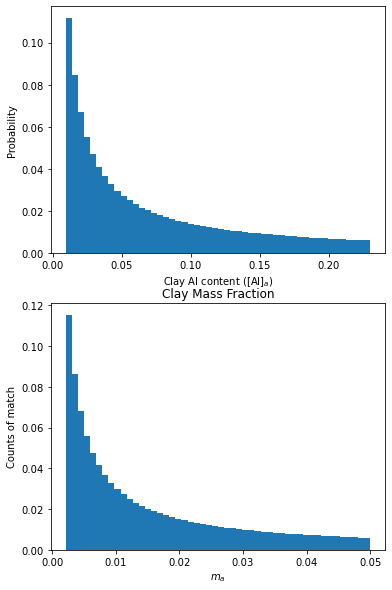

In [18]:
# Plot the distribution of matched values

with np.load('./Ele_const_2.npz') as data:
    
    m_ala = data['m_ala']
    m_m2  = data['m_m2']
    
    bin_num = 50
    
    hist_ala, edge_ala = np.histogram(m_ala, density=True, bins=bin_num)
    hist_m, edge_m     = np.histogram(1-m_m2, density=True, bins=bin_num)
    
    hist_ala = hist_ala*np.diff(edge_ala)
    hist_m   = hist_m*np.diff(edge_m)
    
    f = plt.figure(figsize=(6,10))              # results after matching elemental ratio
    weights = np.ones_like(m_ala) / len(m_ala)
    plt.subplot(2,1,1)
    plt.hist(m_ala, weights=weights, bins=bin_num) 
    plt.ylabel('Probability')
    plt.xlabel(r'Clay Al content ([Al]$_a$)');

    weights = np.ones_like(m_m2) / len(m_m2)
    plt.subplot(2,1,2)
    plt.hist(1-m_m2, weights=weights, bins=bin_num)  # density=False would make counts
    plt.ylabel('Counts of match')
    plt.xlabel(r'$m_a$');
    plt.title('Clay Mass Fraction')